# Gibbs chain verification

In [1]:
import os, sys, time
import numpy as np
import matplotlib.pyplot as plt
import scipy as sp
import healpy as hp
import astropy.io.fits as fits
import camb
import scipy
import toml
import jax
import jax.numpy as jnp
import jax.lax as jlax
import jax.scipy as jsp
import jax_healpy as jhp
import numpyro
from fgbuster.observation_helpers import *
import micmac as micmac

from jax import config
config.update("jax_enable_x64", True)

In [2]:
sys.path.append(os.path.dirname(os.path.abspath('')))
sys.path.append(os.path.dirname(os.path.dirname(os.path.abspath('')))+'/tutorials/')

In [3]:
working_directory_path = os.path.abspath('') + '/'
directory_save_file = working_directory_path + 'save_directory/'
directory_toml_file = working_directory_path + 'main_params/'
directory_additional_params = working_directory_path + 'additional_params/'


# Studying the sampling !

In [4]:
file_ver_ns0 = 'corr_cutsky_SO_d7s0_nside0_v1091c_r0_v1ab9_{}_{}'.format(0,4)
path_additional_params_ns0 = directory_additional_params + 'add_corr_cutsky_SO_d7s0_nside0_v1a.toml'

file_ver_ns1 = 'corr_cutsky_SO_d7s0_nside1_v1091c_r0_v1ab9_{}_{}'.format(0,4)
path_additional_params_ns1 = directory_additional_params + 'add_corr_cutsky_SO_d7s0_nside1_v1a.toml'

file_ver_ns2 = 'corr_cutsky_SO_d7s0_nside2_v1091c_r0_v1b4_{}_{}'.format(0,1)
path_additional_params_ns2 = directory_additional_params + 'add_corr_cutsky_SO_d7s0_nside2_v1a.toml'

file_ver_ns4 = 'corr_cutsky_SO_d7s0_nside4_v1091c_r0_v1ab9_{}_{}'.format(0,1)
path_additional_params_ns4 = directory_additional_params + 'add_corr_cutsky_SO_d7s0_nside4_v1a.toml'

file_ver_ns8 = 'corr_cutsky_SO_d7s0_nside8_v1091c_r0_v1ab9_{}_{}'.format(0,1)
path_additional_params_ns8 = directory_additional_params + 'add_corr_cutsky_SO_d7s0_nside8_v1a.toml'

file_ver_ns16 = 'corr_cutsky_SO_d7s0_nside16_v1091c_r0_v1ab4_{}_{}'.format(0,1)
path_additional_params_ns16 = directory_additional_params + 'add_corr_cutsky_SO_d7s0_nside16_v1a.toml'


In [5]:
list_file_ver = [file_ver_ns0, file_ver_ns1, file_ver_ns2, file_ver_ns4, file_ver_ns8, file_ver_ns16]
list_path_additional_params = [path_additional_params_ns0, path_additional_params_ns1, path_additional_params_ns2, path_additional_params_ns4, path_additional_params_ns8, path_additional_params_ns16]

list_nsides = [0, 1, 2, 4, 8, 16]

In [6]:
fast_verion_bool = True

In [7]:
MICMAC_sampler_obj_list =  []

for path_additional_params in list_path_additional_params:
    with open(path_additional_params) as f:
        dictionary_additional_parameters = toml.load(f)
    f.close()

    directory_mask = dictionary_additional_parameters['directory_mask']
    reduction_noise = dictionary_additional_parameters['reduction_noise']
    # factor_Fisher = dictionary_additional_parameters['factor_Fisher']
    # relative_treshold = dictionary_additional_parameters['relative_treshold']
    # sigma_gap = dictionary_additional_parameters['sigma_gap']
    fgs_model = dictionary_additional_parameters['fgs_model']
    # initial_guess_r = dictionary_additional_parameters['initial_guess_r']
    # use_nhits = dictionary_additional_parameters['use_nhits']
    name_mask = dictionary_additional_parameters['name_mask']
    # use_mask = dictionary_additional_parameters['use_mask']
    name_toml = dictionary_additional_parameters['name_toml']
    name_file_spv = dictionary_additional_parameters['name_file_spv']
    print("Using toml file: ", name_toml)

    path_toml_file = directory_toml_file + name_toml
    if name_file_spv != '':
        path_file_spv = directory_toml_file + name_file_spv
    else:
        path_file_spv = ''

    MICMAC_sampler_obj_list.append(micmac.create_MICMAC_sampler_from_toml_file(path_toml_file, path_file_spv))

Using toml file:  corr_cutsky_SO_r0_v1a.toml
<_io.TextIOWrapper name='/Users/mag/Documents/PHD1Y/Space_Work/Pixel_non_P2D/MICMAC/test_playground/Paper_runs_v3/main_params/params_spv_SAT_nside0.yaml' mode='r' encoding='UTF-8'>
count_b: 8
n_betas:  8

>>> Tree of spv config as passed by the User:
root
  nside_spv
    default: [0]
    f1
      default: None
      b0
        default: None
      b1
        default: None
      b2
        default: None
      b3
        default: None
    f2
      default: [0]
      b0
        default: None
      b1
        default: None
      b2
        default: None
      b3
        default: None

>>> Tree of spv config after filling the missing values:
root
  nside_spv
    default: [0]
    f1
      default: [0]
      b0
        default: [0]
      b1
        default: [0]
      b2
        default: [0]
      b3
        default: [0]
    f2
      default: [0]
      b0
        default: [0]
      b1
        default: [0]
      b2
        default: [0]
      b3
      

In [8]:
list_nsides = np.array([np.unique(MICMAC_sampler_obj_list[i].values_b)[0] for i in range(len(MICMAC_sampler_obj_list))])

In [9]:
MICMAC_sampler_obj = MICMAC_sampler_obj_list[0]

instr_name = MICMAC_sampler_obj.instrument_name

# get instrument from public database
instrument = get_instrument(instr_name)

_, _, theoretical_red_cov_r0_total, theoretical_red_cov_r1_tensor = MICMAC_sampler_obj.generate_input_freq_maps_from_fgs(np.zeros((MICMAC_sampler_obj.n_frequencies,
                                                                                                                                  MICMAC_sampler_obj.nstokes,
                                                                                                                                  MICMAC_sampler_obj.n_pix,)), 
                                                                                                                         return_only_freq_maps=False)

freq_inverse_noise = micmac.get_noise_covar_extended(instrument['depth_p'], MICMAC_sampler_obj.nside)

Calculating spectra from CAMB !
Calculating spectra from CAMB !


In [10]:
initial_freq_maps = []
input_cmb_maps = []
all_eta_maps = []
all_s_c_WF_maps = []
all_s_c_fluct_maps = []
all_s_c_samples = []
all_r_samples = []
all_cell_samples = []
all_params_mixing_matrix_samples = []

for file_ver in list_file_ver:
    # job = 0
    # num_jobs = 1
    # initial_freq_maps_path = directory_save_file+file_ver.format(job,num_jobs)+'_initial_data.npy'
    initial_freq_maps_path = directory_save_file+file_ver+'_initial_data.npy'
    initial_freq_maps.append(np.load(initial_freq_maps_path))

    # initial_cmb_maps_path = directory_save_file+file_ver.format(job,num_jobs)+'_initial_cmb_data.npy'
    initial_cmb_maps_path = directory_save_file+file_ver+'_initial_cmb_data.npy'
    input_cmb_maps.append(np.load(initial_cmb_maps_path))

    if MICMAC_sampler_obj.sample_r_Metropolis:
        # all_r_samples_path = directory_save_file+file_ver.format(job,num_jobs)+'_all_r_samples.npy'
        all_r_samples_path = directory_save_file+file_ver+'_all_r_samples.npy'
        all_r_samples.append(np.load(all_r_samples_path))
    elif MICMAC_sampler_obj.sample_C_inv_Wishart:
        # all_cell_samples_path = directory_save_file+file_ver.format(job,num_jobs)+'_all_cell_samples.npy'
        all_cell_samples_path = directory_save_file+file_ver+'_all_cell_samples.npy'
        all_cell_samples.append(np.load(all_cell_samples_path))

    # all_params_mixing_matrix_samples_path = directory_save_file+file_ver.format(job,num_jobs)+'_all_params_mixing_matrix_samples.npy'
    all_params_mixing_matrix_samples_path = directory_save_file+file_ver+'_all_params_mixing_matrix_samples.npy'
    all_params_mixing_matrix_samples.append(np.load(all_params_mixing_matrix_samples_path))

initial_freq_maps = np.array(initial_freq_maps)
input_cmb_maps = np.array(input_cmb_maps)
# if MICMAC_sampler_obj.sample_r_Metropolis:
#     all_r_samples = np.array(all_r_samples)
# elif MICMAC_sampler_obj.sample_C_inv_Wishart:
#     all_cell_samples = np.array(all_cell_samples)
# all_params_mixing_matrix_samples = np.array(all_params_mixing_matrix_samples)

In [11]:
n_correl_to_plot = int(np.ceil(MICMAC_sampler_obj.nstokes**2/2) + np.floor(MICMAC_sampler_obj.nstokes/2))

if MICMAC_sampler_obj.nstokes == 3:
    number_subplots_convention = 421
    figsize = (10,10)
    figsize_big = (12,12)
    position_legend = int(n_correl_to_plot/2)-1
    bbox_to_anchor=(2.2, 1)
elif MICMAC_sampler_obj.nstokes == 2:
    number_subplots_convention = 131
    figsize = (14,6)
    figsize_big = figsize
    position_legend = n_correl_to_plot-1
    bbox_to_anchor=(1, 1)
else:
    number_subplots_convention = 111
    figsize = (10,10)
    figsize_big = (10,10)
    position_legend = int(n_correl_to_plot/2)-1
    bbox_to_anchor=(2.2, 1)

## Handling mask

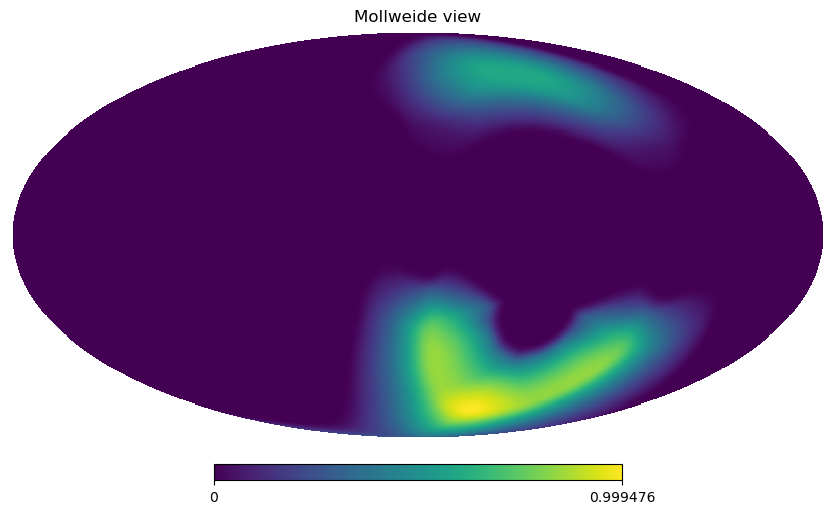

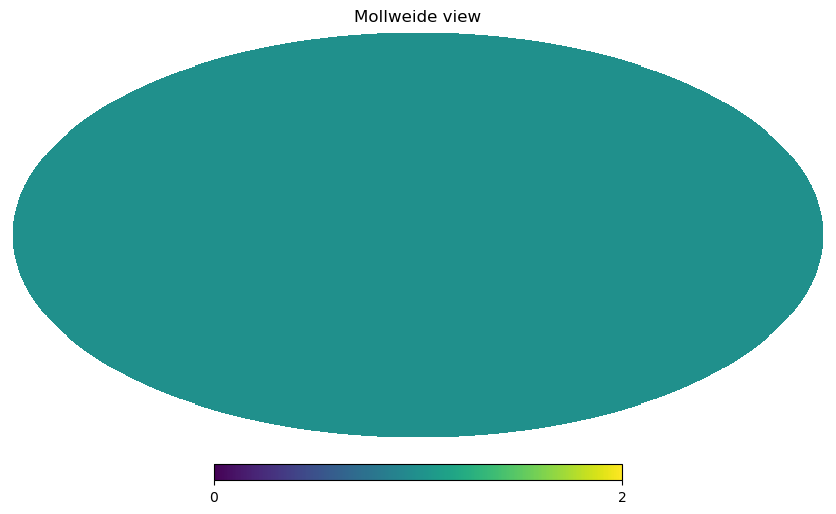

In [12]:
directory_mask_local = '/Users/mag/Documents/PHD1Y/masks/'
path_mask = directory_mask_local + name_mask + '.fits'

if os.path.exists(path_mask):
    mask = hp.read_map(path_mask, verbose=False)

    hp.mollview(mask)

    mask = np.int64(hp.ud_grade(mask, nside_out=MICMAC_sampler_obj.nside, dtype=np.float64))

    MICMAC_sampler_obj.mask = mask

    if MICMAC_sampler_obj.size_patches.max() > 1:
        frequency_Bf = np.array(instrument['frequency'][1:-1])
    number_free_Bf = (MICMAC_sampler_obj.n_frequencies-len(MICMAC_sampler_obj.pos_special_freqs))*(MICMAC_sampler_obj.n_components - 1)
    extended_array = np.zeros((number_free_Bf+1),dtype=np.int64)
    extended_array[:-1] = MICMAC_sampler_obj.indexes_b.ravel(order='F')
    extended_array[-1] = extended_array[:-1].max() + MICMAC_sampler_obj.size_patches[-1]
    
    all_templates = MICMAC_sampler_obj.get_all_templates()%MICMAC_sampler_obj.size_patches[-1] + 1

    hp.mollview(all_templates[0,0] - all_templates[0,0]*mask)
    plt.show()

# Studying $r$

In [13]:
burn_in = int(.9*MICMAC_sampler_obj.number_iterations_sampling)
burn_in = 1500

In [14]:
# if MICMAC_sampler_obj.sample_r_Metropolis:
#     for job in range(num_jobs):
#         plt.figure(figsize=(14,4))
        
#         # n_sigma = 3
        
#         # cond = np.abs((all_r_samples[job] - all_r_samples[job].mean())/(all_r_samples[job].std())) < n_sigma
#         cond = np.arange(MICMAC_sampler_obj.number_iterations_sampling+1) > MICMAC_sampler_obj.number_iterations_sampling + 1 - burn_in
#         print(all_r_samples[job,cond].shape, MICMAC_sampler_obj.number_iterations_sampling)
#         mean_r = np.round(all_r_samples[job,cond].mean(), decimals=5)
#         std_r = np.round(all_r_samples[job,cond].std(), decimals=5)

#         plt.suptitle(f"Mean value $r = {mean_r} \pm {std_r}$")
#         plt.subplot(121)
#         plt.plot(np.arange(MICMAC_sampler_obj.number_iterations_sampling+1), all_r_samples[job], label='r samples')
#         plt.plot([0, MICMAC_sampler_obj.number_iterations_sampling+1], [MICMAC_sampler_obj.r_true,MICMAC_sampler_obj.r_true], 'k:', label='r true')

#         plt.yscale('log')
#         plt.xlabel("Iterations")
#         plt.ylabel('$r$ sample')
#         plt.title('Complete path of $r$')
#         plt.legend()

#         plt.subplot(122)
#         plt.plot(np.arange(MICMAC_sampler_obj.number_iterations_sampling+1), all_r_samples[job], label='r samples')
#         plt.plot([0, MICMAC_sampler_obj.number_iterations_sampling+1], [MICMAC_sampler_obj.r_true,MICMAC_sampler_obj.r_true], 'k:', label='r true')
#         plt.xlabel("Iterations")
#         plt.ylabel('$r$ sample')
#         plt.title('Zoom around true value of $r$')
#         plt.legend()
#         # plt.ylim(ymin=MICMAC_sampler_obj.r_true*.7, ymax=MICMAC_sampler_obj.r_true*1.3)
#     plt.show()

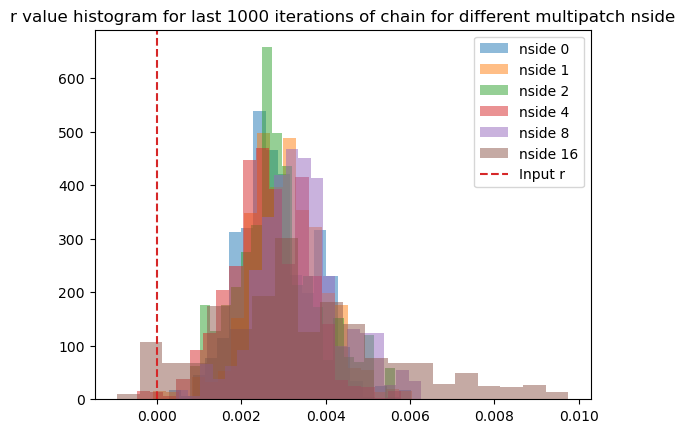

In [15]:
if MICMAC_sampler_obj.sample_r_Metropolis:
    plt.figure()
    plt.title('r value histogram for last 1000 iterations of chain for different multipatch nside')
    for ns in range(len(list_file_ver)):
        # hist_values, bins_value, _ = plt.hist(all_r_samples[ns][-1000:], bins='rice', density=True, label="nside {}".format(list_nsides[ns]))
        hist_values, bins_value, _ = plt.hist(all_r_samples[ns][-1000:], bins='rice', density=True, label="nside {}".format(list_nsides[ns]), alpha=.5)
    plt.axvline(MICMAC_sampler_obj.r_true, color='tab:red', linestyle='--', label='Input r')
    plt.legend()
    plt.show()

In [16]:
cond = MICMAC_sampler_obj.number_iterations_sampling > 1500

In [17]:
c_ell_true_CMB = micmac.get_c_ells_from_red_covariance_matrix_JAX(theoretical_red_cov_r0_total + MICMAC_sampler_obj.r_true*theoretical_red_cov_r1_tensor)

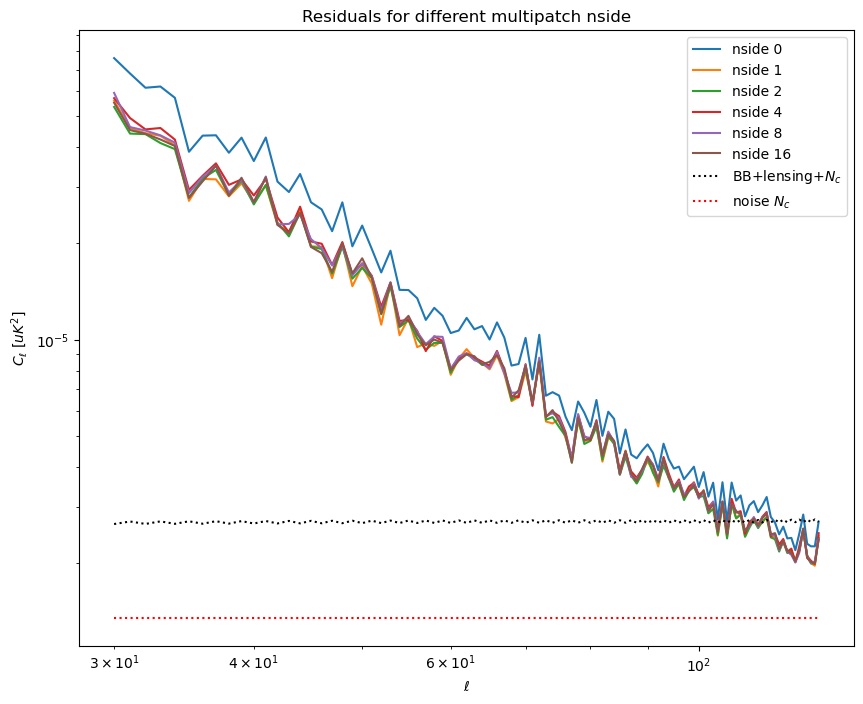

In [18]:
# Residuals power spectrum

indices_polar = np.array([1,2,4])

plt.figure(figsize=(10,8))
plt.title('Residuals for different multipatch nside')
for ns in range(len(list_file_ver)):
    final_params = all_params_mixing_matrix_samples[ns][-1000:].mean(axis=0)
    MICMAC_sampler_obj_list[ns].update_params(final_params)
    final_mixing_matrix = MICMAC_sampler_obj_list[ns].get_B()

    recovered_CMB_Wd = micmac.get_Wd(freq_inverse_noise, final_mixing_matrix, initial_freq_maps[ns], jax_use=False)[0, :, :]

    residuals_Wd = recovered_CMB_Wd - input_cmb_maps[ns,0]

    recovered_CMB_Wd_extended = np.vstack([np.zeros_like(recovered_CMB_Wd[0]), recovered_CMB_Wd])
    c_ells_recovered_CMB_Wd = hp.anafast(recovered_CMB_Wd_extended, lmax=MICMAC_sampler_obj.lmax, iter=MICMAC_sampler_obj.n_iter)[indices_polar,MICMAC_sampler_obj.lmin:]

    residuals_Wd_extended = np.vstack([np.zeros_like(residuals_Wd[0]), residuals_Wd])
    c_ells_residuals_Wd = hp.anafast(residuals_Wd_extended, lmax=MICMAC_sampler_obj.lmax, iter=MICMAC_sampler_obj.n_iter)[indices_polar,MICMAC_sampler_obj.lmin:]


    ell_array = np.arange(c_ells_recovered_CMB_Wd.shape[-1])+MICMAC_sampler_obj.lmin
    # plt.plot(ell_array, c_ells_recovered_CMB_Wd[1,:], label='recovered CMB')
    plt.plot(ell_array, c_ells_residuals_Wd[1,:], label='nside {}'.format(list_nsides[ns]))

init_params = all_params_mixing_matrix_samples[0][0]
MICMAC_sampler_obj_list[0].update_params(init_params)
final_mixing_matrix = MICMAC_sampler_obj_list[ns].get_B()
_cl_noise_harm = micmac.get_Cl_noise(np.array(instrument['depth_p']), final_mixing_matrix.mean(axis=2), MICMAC_sampler_obj.lmax)[0,0,MICMAC_sampler_obj.lmin:]
red_cl_noise_harm = micmac.get_reduced_matrix_from_c_ell(np.array([_cl_noise_harm,_cl_noise_harm,np.zeros_like(_cl_noise_harm)]))
cl_noise_harm = micmac.get_c_ells_from_red_covariance_matrix(red_cl_noise_harm)

plt.plot(ell_array, c_ell_true_CMB[1,:]+cl_noise_harm[1,:], 'k:', label='BB+lensing+$N_c$')
plt.plot(ell_array, cl_noise_harm[1,:], 'r:', label='noise $N_c$')

plt.loglog()
plt.ylabel("$C_\ell$ [$uK^2$]")
plt.xlabel(r"$\ell$")
plt.legend()
plt.show()
